In [1]:
import importlib

import numpy as np
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
from numpy.random import default_rng
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from mapra import prep

rng = np.random.default_rng(12345)
sns.set_theme(style='white')

### Train a predictor on the ELASPIC dataset and test on the ProTherm test set

In [2]:
# re-generate the protherm test set
importlib.reload(prep)
protherm = prep.protherm_dataset()
protherm_df = protherm.dataframe_abbrev({'DATASET': 'reduced_set'})
splits = protherm.uniprot_train_test_split(df=protherm_df, selector={2048:True}, test_size=.2, random_state=332)
test_set = splits['ddg']

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:271: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:271: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/CAGI6/cam_mutants.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:271: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/reduced_set/ddg_test_set_332.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:271: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/fopra/elaspic-training-set-core.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)
/home/quirin/PYTHON/mapra/mapra/prep.py:271: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapr

loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0_protherm.pkl
split 332 targeted 0.2, real test sizes: 0.2020:0.2113:0.2057, record test sizes: 0.1612:0.1565:0.1544


In [3]:
[n for n in dir(test_set) if not n.startswith('_')]

['X',
 'X_test',
 'delta',
 'real_test_size',
 'records_test_size',
 'test_set',
 'y',
 'y_true']

In [4]:
importlib.reload(prep)
data = prep.elaspic_dataset(cheat=False)
data.dataframe

,unique_id,dataset,UniProt_ID,ligand_sequence,MUTATION,ddg,provean_score,foldx_score,elaspic_score,DATASET,DELTA
0,3629188840,ab_bind,pdb1ffw.entA_0,None,A89V,0.09,-3.876,0.32746,0.310814,both,ddg
1,3629188840,ab_bind,pdb1ffw.entA_0,None,D12K,0.05,-6.809,-1.56159,0.110331,both,ddg
2,3629188840,ab_bind,pdb1ffw.entA_0,None,E116K,0.71,-1.206,-0.11701,0.102771,both,ddg
3,3629188840,ab_bind,pdb1ffw.entA_0,None,E92K,0.82,-3.911,1.11057,0.584293,both,ddg
4,3629188840,ab_bind,pdb1ffw.entA_0,None,F110V,1.26,-6.873,4.522226,2.758522,both,ddg
...,...,...,...,...,...,...,...,...,...,...,...
20607,1821162748,taipale_ppi,P04075.2:364,None,C338Y,0.0,-3.859,10.396,0.840431,both,ddg
20608,1204240423,taipale_ppi,Q03393.8:145,None,R9C,0.0,-5.021,0.4673,1.01085,both,ddg
20609,1204240423,taipale_ppi,Q03393.8:145,None,F33L,0.0,-5.532,1.2239,1.35122,both,ddg
20610,1204240423,taipale_ppi,Q03393.8:145,None,K84R,0.0,-2.836,0.4097,0.753752,both,ddg


In [5]:
npr = data.fetch_numpy_distances(
    selector={'DATASET': ['cdhit', 'both'], 2048: True})
npr

loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0_elaspic.pkl


array([[ 0.      ,  0.09    , -0.25    , ..., -0.2275  ,  0.1567  ,
        -0.02144 ],
       [ 0.      ,  0.05    , -0.4932  , ...,  0.03943 ,  0.03046 ,
        -0.0645  ],
       [ 0.      ,  0.71    ,  0.361   , ..., -0.2693  ,  0.3032  ,
        -0.0911  ],
       ...,
       [ 0.      ,  0.      , -0.1821  , ..., -0.2164  ,  0.103   ,
        -0.274   ],
       [ 0.      ,  0.      ,  0.11395 , ...,  0.003887, -0.03162 ,
        -0.006706],
       [ 0.      ,  1.      , -0.2888  , ...,  0.1665  ,  0.2812  ,
        -0.4958  ]], dtype=float16)

In [6]:
X = npr[:, 2:]
y = npr[:, 1]
X.shape, y.shape

((19420, 2048), (19420,))

In [7]:
X, y

(array([[-0.25    , -0.1577  ,  0.05203 , ..., -0.2275  ,  0.1567  ,
         -0.02144 ],
        [-0.4932  , -0.558   ,  0.1484  , ...,  0.03943 ,  0.03046 ,
         -0.0645  ],
        [ 0.361   , -0.099   ,  0.248   , ..., -0.2693  ,  0.3032  ,
         -0.0911  ],
        ...,
        [-0.1821  ,  0.274   ,  0.02225 , ..., -0.2164  ,  0.103   ,
         -0.274   ],
        [ 0.11395 ,  0.1495  ,  0.309   , ...,  0.003887, -0.03162 ,
         -0.006706],
        [-0.2888  ,  0.1066  , -0.10645 , ...,  0.1665  ,  0.2812  ,
         -0.4958  ]], dtype=float16),
 array([0.09, 0.05, 0.71, ..., 0.  , 0.  , 1.  ], dtype=float16))

In [16]:
# train on the entire elaspic set
# regr = linear_model.LassoLarsCV(
#     n_jobs=-1)  #, max_iter=1000, cv=5)
# regr.fit(X, y.flatten())
regr = linear_model.LassoLarsIC(
    criterion='aic', copy_X=True)
regr.fit(X.astype(float), y.flatten().astype(float))

LassoLarsIC()

In [17]:
# make a prediction
y_pred = regr.predict(test_set.X_test).reshape(-1, 1)
# save the prediction
ar = np.hstack((y_pred, test_set.y_true))


In [18]:
test_set.X.shape, X.shape, test_set.y.flatten().shape, y.flatten().shape

((1639, 2048), (19420, 2048), (1639,), (19420,))

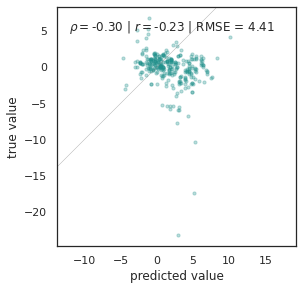

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4.4, 4.4))
cm_color = sns.color_palette('viridis', 3)[1]

sns.regplot(ax=ax,
            x=ar[:, 0], y=ar[:, 1],
            color=cm_color,
            # marker='+',
            scatter_kws={'s': 10, 'alpha': .3},
            fit_reg=False, logistic=True)

ax.set(aspect=1, box_aspect=1)
# ax.set(title=data.tex_lookup[delta] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])
ax.axline((0, 0), slope=1, lw=.5, color='.5', alpha=.6)

# correlations
sp, pval = scipy.stats.spearmanr(ar, axis=0)
pcorr = np.corrcoef(ar, rowvar=False)[0, 1]
rmse = mean_squared_error(ar[:, 1], ar[:, 0], squared=False)
r2 = r2_score(ar[:, 1], ar[:, 0])

ax.text(.05, .9, r"$\rho = $" + f'{sp:.2f} | ' + r"$r = $" + f'{pcorr:.2f} | RMSE = {rmse:.2f}',
        transform=ax.transAxes)
# axes[0].set_title(desc % test_size, loc='left', fontsize='xx-large', pad=12)

# fig.subplots_adjust(bottom=0.002)
ax.set(ylabel='true value', xlabel='predicted value')
prep.save(fig, f'332_2048_cdhit.png')
prep.save(fig, f'332_2048_cdhit.svg')

### Train and test on ELASPIC?

loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0_elaspic.pkl
split 330 targeted 0.2, real test sizes: 0.2009, record test sizes: 0.1965
loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0_elaspic.pkl
split 331 targeted 0.2, real test sizes: 0.2009, record test sizes: 0.2740
loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0_elaspic.pkl
split 332 targeted 0.2, real test sizes: 0.2009, record test sizes: 0.2141
loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0_elaspic.pkl
split 333 targeted 0.2, real test sizes: 0.2009, record test sizes: 0.1807
loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0_elaspic.pkl
split 334 targeted 0.2, real test sizes: 0.2009, record test sizes: 0.1459
loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0_elaspic.pkl
split 335 targeted 0.2, real test sizes: 0.2009, record test sizes: 0.1383
loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0_elaspic.pkl
split 336 targeted 0.2, real test sizes: 0.2009, record test sizes: 0.3430
loading from 

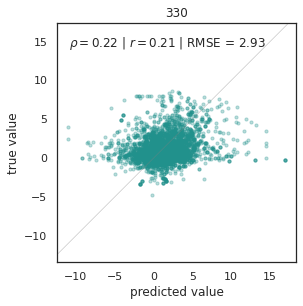

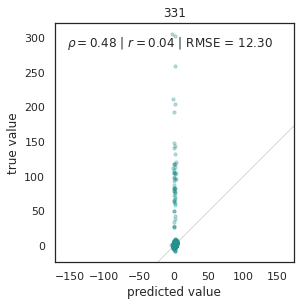

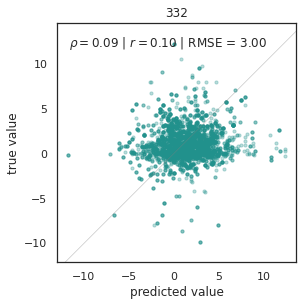

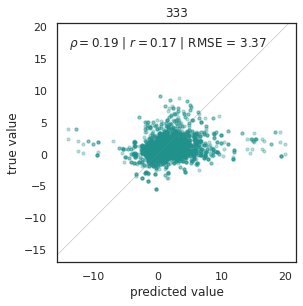

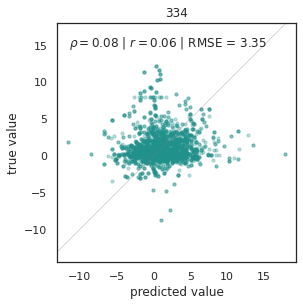

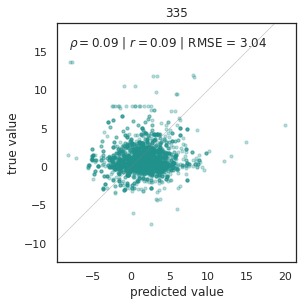

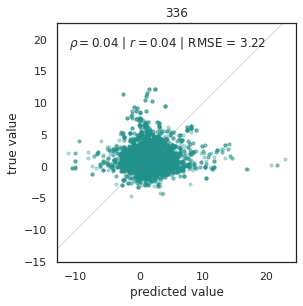

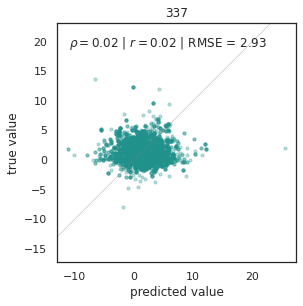

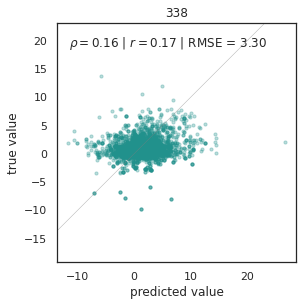

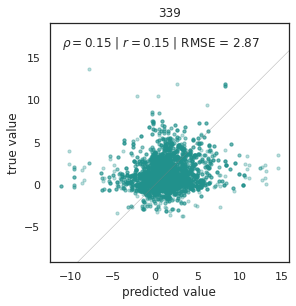

In [31]:
data = prep.elaspic_dataset(cheat=False)

test_size = .2
seed = rng.integers(low=0, high=1000, size=1)[0]
seed = 332
for seed in range(330, 340):
    desc = 'test size: %.1f'

    split = data.uniprot_train_test_split(
        selector={'DATASET': ['mmseqs', 'both']}, test_size=test_size, random_state=seed)['ddg']

    # regr = linear_model.LassoLarsCV(
    #     n_jobs=-1, max_iter=1000, cv=5)
    # regr.fit(split.X, split.y.flatten())
    regr = linear_model.LassoLarsIC(
        criterion='aic', copy_X=True)
    regr.fit(split.X.astype(float), split.y.flatten().astype(float))

    # make a prediction
    y_pred = regr.predict(split.X_test).reshape(-1, 1)
    # save the prediction
    ar = np.hstack((y_pred, split.y_true))

    fig, ax = plt.subplots(1, 1, figsize=(4.4, 4.4))

    sns.regplot(ax=ax,
                x=ar[:, 0], y=ar[:, 1],
                color=cm_color,
                # marker='+',
                scatter_kws={'s': 10, 'alpha': .3},
                fit_reg=False, logistic=True)

    ax.set(aspect=1, box_aspect=1)
    # ax.set(title=data.tex_lookup[delta] + [' [°C]', ' [kcal/mol]', ' [kcal/mol]'][i])
    ax.axline((0, 0), slope=1, lw=.5, color='.5', alpha=.6)

    # correlations
    sp, pval = scipy.stats.spearmanr(ar, axis=0)
    pcorr = np.corrcoef(ar, rowvar=False)[0, 1]
    rmse = mean_squared_error(ar[:, 1], ar[:, 0], squared=False)
    r2 = r2_score(ar[:, 1], ar[:, 0])

    ax.text(.05, .9, r"$\rho = $" + f'{sp:.2f} | ' + r"$r = $" + f'{pcorr:.2f} | RMSE = {rmse:.2f}',
            transform=ax.transAxes)
    # axes[0].set_title(desc % test_size, loc='left', fontsize='xx-large', pad=12)

    # fig.subplots_adjust(bottom=0.002)
    ax.set(ylabel='true value', xlabel='predicted value', title=seed)
    prep.save(fig, f'elaspic_on_elaspic_{test_size}_seed_{seed}.png')